c:\Users\miyun\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\fft\_helper.py:170: RuntimeWarning: divide by zero encountered in scalar divide
  val = 1.0 / (n * d)
c:\Users\miyun\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\fft\_helper.py:177: RuntimeWarning: invalid value encountered in multiply
  return results * val


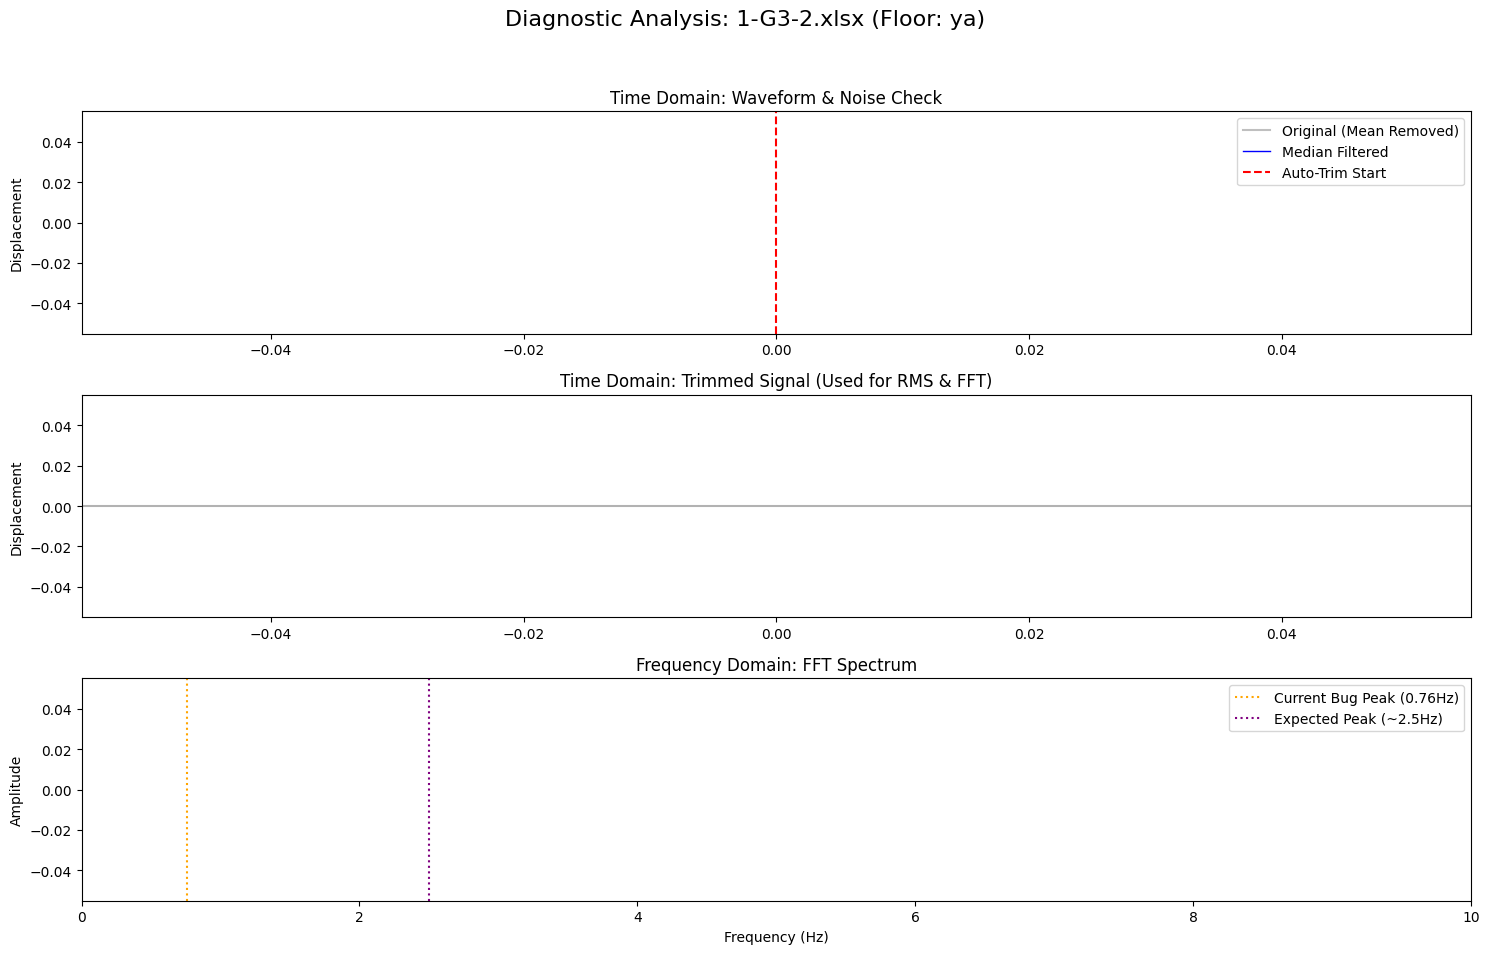

診斷數據:
- 原始數據平均值 (Offset): nan
- 裁切後 RMS: nan


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.signal import medfilt

def auto_trim_index(y, threshold_factor=3.0, window_size=20):
    """
    偵測數據開始劇烈波動的索引位置
    y: 數據數組
    threshold_factor: 偵測門檻（噪訊標準差的幾倍），若切太多可以調高此數值
    window_size: 滑動窗口大小
    """
    if len(y) < window_size:
        return 0
    
    # 以開頭一小段（前100點）計算基礎環境噪訊的標準差
    base_std = np.std(y[:min(100, len(y))])
    
    # 轉換成 pandas Series 計算滑動標準差
    y_series = pd.Series(y)
    rolling_std = y_series.rolling(window=window_size).std().fillna(0).values
    
    # 找到第一個顯著超過噪訊門檻的地方
    trigger_threshold = base_std * threshold_factor
    indices = np.where(rolling_std > trigger_threshold)[0]
    
    if len(indices) > 0:
        # 往前回溯一個窗口大小，確保包含完整的起跳波形
        return max(0, indices[0] - window_size)
    
    return 0


# 設定目標檔案
target_file = "E:/EarthScienceFair_Data/1/G3/1-G3-2.xlsx"

def diagnostic_plot(file_path):
    try:
        df = pd.read_excel(file_path)
        # 讀取數據 (ya 是最後一欄，t_s 是第一欄)
        t_s_raw = pd.to_numeric(df.iloc[:, 0], errors='coerce').fillna(0).values
        ya_raw = pd.to_numeric(df.iloc[:, 5], errors='coerce').interpolate().values # ya 在第6欄
        
        # 1. 基礎處理
        t_s = t_s_raw - t_s_raw[0]
        # 去中心化 (對診斷很重要，看看原始偏離多少)
        ya_mean_removed = ya_raw - np.mean(ya_raw)
        
        # 2. 濾波處理
        ya_med = medfilt(ya_mean_removed, kernel_size=5)
        
        # 3. 偵測裁切點
        start_idx = auto_trim_index(ya_med) # 調用先前定義的函數
        
        # 4. FFT 計算
        N = len(ya_med[start_idx:])
        dt = np.mean(np.diff(t_s))
        yf = fft(ya_med[start_idx:])
        xf = fftfreq(N, dt)[:N//2]
        amplitude = 2.0/N * np.abs(yf[:N//2])

        # --- 開始繪圖 ---
        plt.figure(figsize=(15, 10))
        plt.suptitle(f"Diagnostic Analysis: {os.path.basename(file_path)} (Floor: ya)", fontsize=16)

        # 圖一：原始波形與裁切點
        plt.subplot(3, 1, 1)
        plt.plot(t_s, ya_mean_removed, label='Original (Mean Removed)', color='gray', alpha=0.5)
        plt.plot(t_s, ya_med, label='Median Filtered', color='blue', linewidth=1)
        plt.axvline(x=t_s[start_idx], color='red', linestyle='--', label='Auto-Trim Start')
        plt.title("Time Domain: Waveform & Noise Check")
        plt.ylabel("Displacement")
        plt.legend()

        # 圖二：裁切後的精確波形 (檢查有無 DC Offset)
        plt.subplot(3, 1, 2)
        plt.plot(t_s[start_idx:], ya_med[start_idx:], color='green')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.title("Time Domain: Trimmed Signal (Used for RMS & FFT)")
        plt.ylabel("Displacement")

        # 圖三：頻譜圖 (檢查 0.76Hz 與 2.5Hz 的能量)
        plt.subplot(3, 1, 3)
        plt.plot(xf, amplitude, color='red')
        plt.xlim(0, 10) # 只看 0-10 Hz
        plt.axvline(x=0.76, color='orange', linestyle=':', label='Current Bug Peak (0.76Hz)')
        plt.axvline(x=2.5, color='purple', linestyle=':', label='Expected Peak (~2.5Hz)')
        plt.title("Frequency Domain: FFT Spectrum")
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("Amplitude")
        plt.legend()

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

        print(f"診斷數據:")
        print(f"- 原始數據平均值 (Offset): {np.mean(ya_raw):.4f}")
        print(f"- 裁切後 RMS: {np.sqrt(np.mean(ya_med[start_idx:]**2)):.4f}")
        
    except Exception as e:
        print(f"診斷失敗: {e}")

diagnostic_plot(target_file)